# 3. Three-dimensional analysis
The objective of this final notebook is to familiarise ourselves with the three-dimensional or spectro-morphological analysis.

In [52]:
import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord
from regions import PointSkyRegion, CircleSkyRegion
import matplotlib.pyplot as plt

# %matplotlib inline
from IPython.display import display
from gammapy.data import FixedPointingInfo, Observation, observatory_locations
from gammapy.datasets import MapDataset
from gammapy.irf import load_irf_dict_from_file
from gammapy.makers import MapDatasetMaker, SafeMaskMaker
from gammapy.maps import Map, MapAxis, WcsGeom
from gammapy.modeling import Fit
from gammapy.modeling.models import (
    Models,
    SkyModel,
    FoVBackgroundModel,
    PointSpatialModel,
    GaussianSpatialModel,
    ShellSpatialModel,
    PowerLawSpectralModel,
    ExpCutoffPowerLawSpectralModel,
)

Let us simulate the data ourselves. Let us use three sources

In [23]:
# - source 1
spectral_model_1 = ExpCutoffPowerLawSpectralModel(
    amplitue = 5e-12 * u.Unit("TeV-1 cm-2 s-1"),
    index=1.5,
    reference=1 * u.TeV,
    lambda_ = 1 / (3 * u.TeV) # a cutoff at 10 TeV
)
spatial_model_1 = PointSpatialModel(lon_0="0 deg", lat_0="0 deg", frame="galactic")
model_1 = SkyModel(spectral_model_1, spatial_model_1, name="point source")

# - source 2
spectral_model_2 = PowerLawSpectralModel(
    amplitude = 3e-12 * u.Unit("TeV-1 cm-2 s-1"),
    index = 2,
    reference = 1 * u.TeV
)
spatial_model_2 = GaussianSpatialModel(
    lon_0="0.4 deg",
    lat_0="0.15 deg",
    sigma=0.2 * u.deg,
    frame="galactic"
)
model_2 = SkyModel(spectral_model_2, spatial_model_2, name="gaussian")

# - source 3
spectral_model_3 = PowerLawSpectralModel(
    amplitude = 1e-11 * u.Unit("TeV-1 cm-2 s-1"),
    index=2.7,
    reference= 1 * u.TeV
)
spatial_model_3 = ShellSpatialModel(
    lon_0="0.06 deg",
    lat_0="0.6 deg",
    radius=0.6 * u.deg,
    width=0.3 * u.deg,
    frame="galactic",
)
model_3 = SkyModel(spectral_model_3, spatial_model_3, name="shell")

# let us add a Background as well!
bkg_model = FoVBackgroundModel(dataset_name="dataset-simu")

models_simu = Models([model_1, model_2, model_3, bkg_model])

In [3]:
spatial_model_1.to_region()

<PointSkyRegion(center=<SkyCoord (Galactic): (l, b) in deg
    (0., 0.)>)>

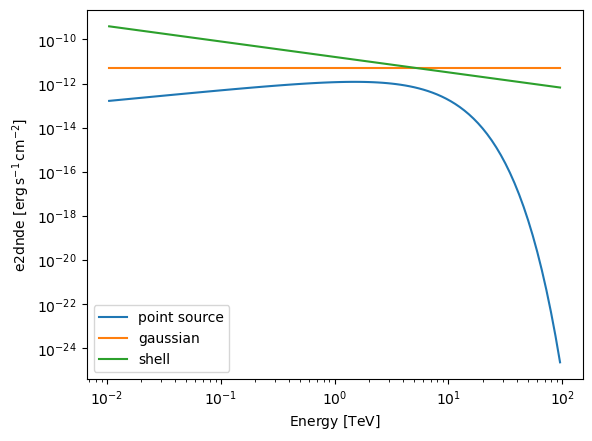

In [4]:
# let us make a quick plot of the spectrum of the three sources
energy_bounds = [10 * u.GeV, 100 * u.TeV]
model_1.spectral_model.plot(
    energy_bounds,
    sed_type="e2dnde",
    label="point source"
)
model_2.spectral_model.plot(
    energy_bounds,
    sed_type="e2dnde",
    label="gaussian"
)
model_3.spectral_model.plot(
    energy_bounds,
    sed_type="e2dnde",
    label="shell"
)
plt.legend()
plt.show()

In [8]:
# Loading IRFs
irfs = load_irf_dict_from_file(
    "$GAMMAPY_DATA/cta-1dc/caldb/data/cta/1dc/bcf/South_z20_50h/irf_file.fits"
)

# Define the observation parameters (typically the observation duration and the pointing position):
livetime = 3.0 * u.hr
pointing_position = SkyCoord(0, 0, unit="deg", frame="galactic")
# We want to simulate an observation pointing at a fixed position in the sky.
# For this, we use the `FixedPointingInfo` class
pointing = FixedPointingInfo(
    fixed_icrs=pointing_position.icrs,
)

# Define map geometry for binned simulation
energy_reco = MapAxis.from_edges(
    np.logspace(-1, 2, 15), unit="TeV", name="energy", interp="log"
)
geom = WcsGeom.create(
    skydir=(0, 0),
    binsz=0.02,
    width=(6, 6),
    frame="galactic",
    axes=[energy_reco],
)
# It is usually useful to have a separate binning for the true energy axis
energy_true = MapAxis.from_edges(
    np.logspace(-2, 3, 50), unit="TeV", name="energy_true", interp="log"
)

empty = MapDataset.create(geom, name="dataset-simu", energy_axis_true=energy_true)

Invalid unit found in background table! Assuming (s-1 MeV-1 sr-1)


In [9]:
# Create an in-memory observation
location = observatory_locations["cta_south"]
obs = Observation.create(
    pointing=pointing, livetime=livetime, irfs=irfs, location=location
)
print(obs)

# Make the MapDataset
maker = MapDatasetMaker(selection=["exposure", "background", "psf", "edisp"])

maker_safe_mask = SafeMaskMaker(methods=["offset-max"], offset_max=4.0 * u.deg)

dataset = maker.run(empty, obs)
dataset = maker_safe_mask.run(dataset, obs)

# Add the model on the dataset and Poisson fluctuate
dataset.models = models_simu
dataset.fake(0)

# do a print on the dataset - there is now a counts maps
print(dataset)

Observation

	obs id            : 0 
 	tstart            : 51544.00
	tstop             : 51544.12
	duration          : 10800.00 s
	pointing (icrs)   : 266.4 deg, -28.9 deg

	deadtime fraction : 0.0%

MapDataset
----------

  Name                            : dataset-simu 

  Total counts                    : 253552 
  Total background counts         : 243103.96
  Total excess counts             : 10448.04

  Predicted counts                : 253500.94
  Predicted background counts     : 243103.96
  Predicted excess counts         : 10396.98

  Exposure min                    : 1.57e+01 m2 s
  Exposure max                    : 5.66e+10 m2 s

  Number of total bins            : 1260000 
  Number of fit bins              : 1251432 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 682773.64

  Number of models                : 4 
  Number of parameters            : 25
  Number of free parameters       : 17

  Component 0: SkyModel
  
    Name                   

Let us plot what we have simulated, we can see the contribution of the different sources in the different energy bins. Let us first examine an interactive plot and then let us make different plots in different energy bins with contours of the sources we have simulated.

In [10]:
dataset.counts.smooth(0.05 * u.deg).plot_interactive(add_cbar=True, stretch="linear")
plt.show()

interactive(children=(SelectionSlider(continuous_update=False, description='Select energy:', layout=Layout(wid…

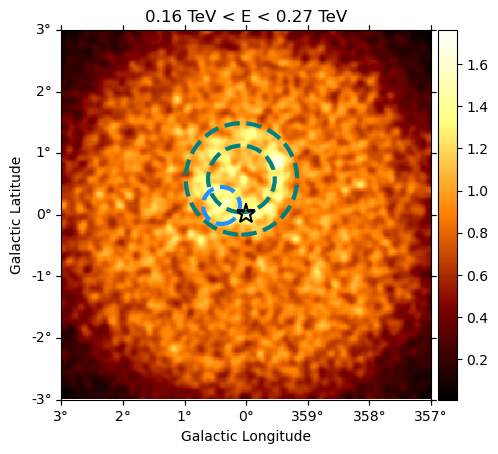

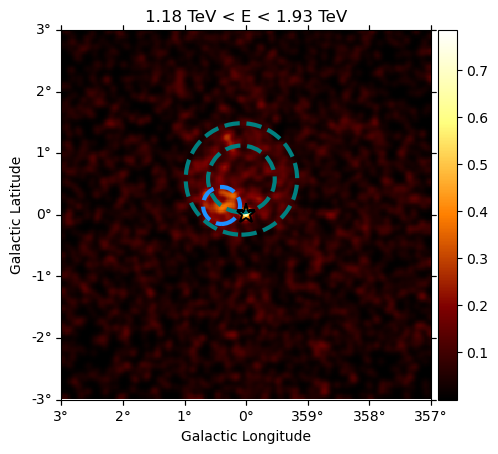

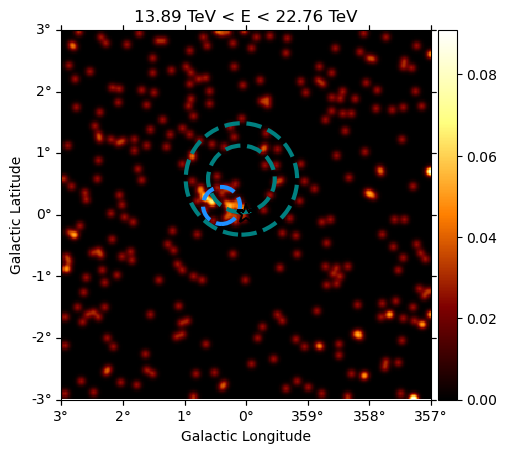

In [21]:
energy_edges =  dataset.counts.geom.axes["energy"].edges

for idx in (1, 5, 10):

    counts_map = dataset.counts.slice_by_idx({"energy":idx})
    wcs = counts_map.geom.wcs
    
    ax = counts_map.smooth(0.05 * u.deg).plot(add_cbar=True, stretch="linear")
    region_source_1 = spatial_model_1.to_region()
    region_source_1.to_pixel(wcs).plot(ax=ax, color="k", marker="*", markersize=14, markeredgewidth=1.5)
    
    region_source_2 = spatial_model_2.to_region()
    region_source_2.to_pixel(wcs).plot(ax=ax, color="dodgerblue", ls="--", lw=3)
    
    region_source_3 = spatial_model_3.to_region()
    region_source_3.to_pixel(wcs).plot(ax=ax, color="teal", ls="--", lw=3)

    e_min = energy_edges[idx]
    e_max = energy_edges[idx + 1]
    
    ax.set_title(f"{e_min:.2f} < E < {e_max:.2f}")
    plt.show()

Let us perform the fit now. But let us see first what happens if we do not include one of the simulated sources in our modelling.

In [18]:
models_fit = Models([model_1, model_3, bkg_model])

# We do not want to fit the background in this case, so we will freeze the parameters
models_fit["dataset-simu-bkg"].spectral_model.norm.frozen = True
models_fit["dataset-simu-bkg"].spectral_model.tilt.frozen = True

dataset.models = models_fit

DatasetModels

Component 0: SkyModel

  Name                      : point source
  Datasets names            : None
  Spectral model type       : ExpCutoffPowerLawSpectralModel
  Spatial  model type       : PointSpatialModel
  Temporal model type       : 
  Parameters:
    index                         :      1.385   +/-    0.00             
    amplitude                     :   1.00e-12   +/- 0.0e+00 1 / (TeV s cm2)
    reference             (frozen):      1.000       TeV         
    lambda_                       :      0.392   +/-    0.00 1 / TeV     
    alpha                 (frozen):      1.000                   
    lon_0                         :      0.006   +/-    0.00 deg         
    lat_0                         :      0.003   +/-    0.00 deg         

Component 1: SkyModel

  Name                      : shell
  Datasets names            : None
  Spectral model type       : PowerLawSpectralModel
  Spatial  model type       : ShellSpatialModel
  Temporal model type       : 

In [19]:
%%time
# let us fit it!
fit = Fit()
results = fit.run(datasets=[dataset])
print(results)
print(models_fit)

OptimizeResult

	backend    : minuit
	method     : migrad
	success    : False
	message    : Optimization failed. Estimated distance to minimum too large.
	nfev       : 498
	total stat : 683485.39

CovarianceResult

	backend    : minuit
	method     : hesse
	success    : True
	message    : Hesse terminated successfully.

Models

Component 0: SkyModel

  Name                      : point source
  Datasets names            : None
  Spectral model type       : ExpCutoffPowerLawSpectralModel
  Spatial  model type       : PointSpatialModel
  Temporal model type       : 
  Parameters:
    index                         :      1.381   +/-    0.15             
    amplitude                     :   1.00e-12   +/- 1.3e-13 1 / (TeV s cm2)
    reference             (frozen):      1.000       TeV         
    lambda_                       :      0.393   +/-    0.07 1 / TeV     
    alpha                 (frozen):      1.000                   
    lon_0                         :      0.006   +/-    0.0

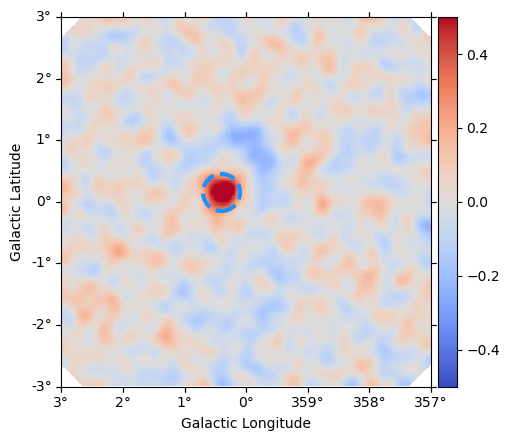

In [22]:
ax = dataset.plot_residuals_spatial(method="diff/sqrt(model)", vmin=-0.5, vmax=0.5)
region_source_2.to_pixel(wcs).plot(ax=ax, color="dodgerblue", ls="--", lw=3)
plt.show()

Let us include now all the sources in the fit.

In [24]:
models_fit = models_simu.copy()

# We do not want to fit the background in this case, so we will freeze the parameters
models_fit["dataset-simu-bkg"].spectral_model.norm.frozen = True
models_fit["dataset-simu-bkg"].spectral_model.tilt.frozen = True

# assign the model to the data set
dataset.models = models_fit

# fit it again!
fit = Fit()
results = fit.run(datasets=[dataset])
print(results)
print(models_fit)

OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 954
	total stat : 682760.32

CovarianceResult

	backend    : minuit
	method     : hesse
	success    : True
	message    : Hesse terminated successfully.

Models

Component 0: SkyModel

  Name                      : point source
  Datasets names            : None
  Spectral model type       : ExpCutoffPowerLawSpectralModel
  Spatial  model type       : PointSpatialModel
  Temporal model type       : 
  Parameters:
    index                         :      1.287   +/-    0.17             
    amplitude                     :   1.07e-12   +/- 1.7e-13 1 / (TeV s cm2)
    reference             (frozen):      1.000       TeV         
    lambda_                       :      0.440   +/-    0.09 1 / TeV     
    alpha                 (frozen):      1.000                   
    lon_0                         :      0.004   +/-    0.00 deg         
    lat_0 

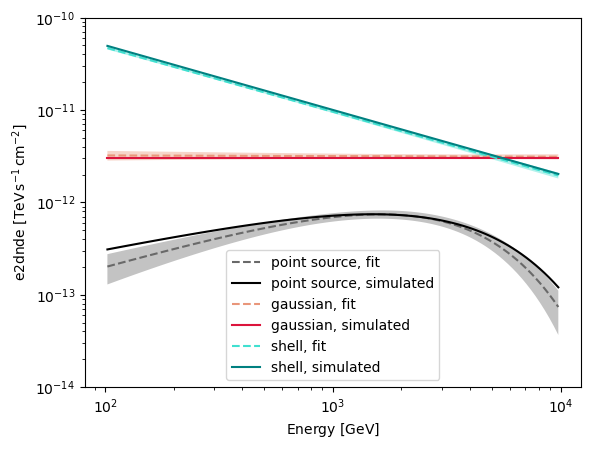

In [71]:
fig, ax = plt.subplots()

plot_kwargs = {
    "sed_type": "e2dnde",
    "yunits": u.Unit("TeV cm-2 s-1"),
    "xunits": u.GeV,
}

energy_range = [100 * u.GeV, 10 * u.TeV]

models_fit[0].spectral_model.plot(
    energy_range,
    ax=ax,
    color="dimgray",
    ls="--",
    label="point source, fit",
    **plot_kwargs,
)
models_fit[0].spectral_model.plot_error(
    energy_range, ax=ax, facecolor="dimgray", alpha=0.4, **plot_kwargs
)
model_1.spectral_model.plot(
    energy_range,
    ax=ax,
    color="k",
    ls="-",
    label="point source, simulated",
    **plot_kwargs,
)

models_fit[1].spectral_model.plot(
    energy_range,
    ax=ax,
    color="darksalmon",
    ls="--",
    label="gaussian, fit",
    **plot_kwargs,
)
models_fit[1].spectral_model.plot_error(
    energy_range, ax=ax, facecolor="darksalmon", alpha=0.4, **plot_kwargs
)
model_2.spectral_model.plot(
    energy_range,
    ax=ax,
    color="crimson",
    ls="-",
    label="gaussian, simulated",
    **plot_kwargs,
)

models_fit[2].spectral_model.plot(
    energy_range,
    ax=ax,
    color="turquoise",
    ls="--",
    label="shell, fit",
    **plot_kwargs,
)
models_fit[2].spectral_model.plot_error(
    
    energy_range, ax=ax, facecolor="turquoise", alpha=0.4, **plot_kwargs
)
model_3.spectral_model.plot(
    energy_range,
    ax=ax,
    color="teal",
    ls="-",
    label="shell, simulated",
    **plot_kwargs,
)

ax.set_ylim([1e-14, 1e-10])
ax.legend()
plt.show()

Let us examine how each source contribute to the counts within the region marked by the outer edge of the shell.

In [53]:
counts_region = CircleSkyRegion(
    center=spatial_model_3.to_region().center,
    radius=spatial_model_3.to_region().outer_radius,
)

spec = dataset.to_spectrum_dataset(counts_region, containment_correction=True)

# - predict the counts from the first source
so1 = SkyModel(models_fit[0].spectral_model)
spec.models = [so1]
npred_1 = Map.from_geom(spec.counts.geom)
npred_1.data = spec.npred_signal().data

# - predict the counts from the second source
so2 = SkyModel(models_fit[1].spectral_model)
spec.models = [so2]
npred_2 = Map.from_geom(spec.counts.geom)
npred_2.data = spec.npred_signal().data
npred_2.data *= (
    models_fit[1].spatial_model.integrate_geom(spec.counts.geom).quantity.to_value("")
)

# - predict the counts from the third source
so3 = SkyModel(models_fit[2].spectral_model)
spec.models = [so3]
npred_3 = Map.from_geom(spec.counts.geom)
npred_3.data = spec.npred_signal().data
npred_3.data *= (
    models_fit[2].spatial_model.integrate_geom(spec.counts.geom).quantity.to_value("")
)

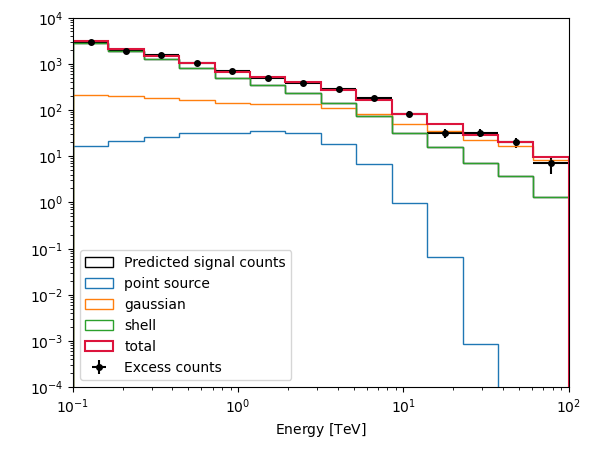

In [70]:
fig, ax = plt.subplots()

spec.plot_excess(color="k")

npred_1.plot_hist(label="point source")
npred_2.plot_hist(label="gaussian")
npred_3.plot_hist(label="shell")
(npred_1 + npred_2 + npred_3).plot_hist(ax=ax, label="total", lw=1.5, color="crimson")

ax.legend()
ax.set_ylim([1e-4, 1e4])
plt.show()